### Project 1
**3180105843 汪奕晨**

用遗传算法近似求解TSP

In [163]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

class tsp_genetic():
    def __init__(self, Dots, group_size = 1000, p_tuple=(0,0.5,0.5)):
        if Dots.shape[0] != 2:
            raise ValueError('输入的点并非二维！')
        if np.sum(p_tuple) != 1:
            print(p_tuple)
            raise ValueError('三个概率的和不为1！')

        self.Dots = Dots
        self.n = Dots.shape[1] # 点的数目

        self.pr = p_tuple[0]
        self.pc = p_tuple[1]
        self.pm = p_tuple[2]
        self.k = (0.4, 0.3, 0.4, 0.1)
        

        self.Graph = np.zeros((self.n,self.n)) # 距离矩阵
        

        # 生成距离矩阵
        for i in range(self.n):
            for j in range(self.n):
                if i != j:
                    self.Graph[i][j] = self.Graph[j][i] =  np.sqrt( (Dots[0,i] - Dots[0,j])**2 + (Dots[1,i] - Dots[1,j])**2 ) 
        
        
        self.reset_group(group_size)
        # self.group_size = group_size    # 种群大小
        # self.Group = np.zeros((self.group_size, self.n)) # 每行为一个个体

        self.distance = self.gen_distance(self.Group)
        self.fitness = self.gen_fitness(self.Group)

        # 维护一个distance的和, 用于cross_over mutation_over时更新
        # 目的是在cross/mutate时记录父本的距离 与新子代对比，可以自适应地调整pc,pr,pm
        # 在某些自适应方法中需要记录这个值
        # self.dc = 0
        # self.dm = 0

    
    # 重置种群
    def reset_group(self, group_size):
        self.group_size = group_size
        self.Group = np.zeros((self.group_size, self.n)) # 每行为一个个体

        # 生成种群
        x = np.arange(self.n)
        for i in range(self.group_size):
            np.random.shuffle(x)
            self.Group[i] = x


    # 随机抽取
    def rand_choose(self, pdf, times = 1):
        if len(pdf) != self.group_size: # 需抽取的总数
            raise ValueError('pdf的长度与group_size不一致')

        pdf_normed = pdf/np.sum(pdf)
        n = self.group_size
        c = np.arange(n) # 抽取的值列表

        return np.random.choice(c,times, p=pdf_normed.ravel())  

    # 计算距离
    def gen_distance(self, paths):
        if paths.shape[1] != self.n:
            raise ValueError('输入的路径与矩阵维度不一致')

        d = np.zeros(paths.shape[0])
        for j in range(paths.shape[0]):
            path = paths[j]
            for i in range(self.n -1):
                d[j] += self.Graph[int(path[i])][int(path[i+1])]
            d[j] += self.Graph[int(path[-1])][int(path[0])]
        return d


    # 计算适合度
    def gen_fitness(self, paths):
        d = self.gen_distance(paths)
        # d最小化 fit最大化
        # return np.exp(1/d)
        return np.exp(np.max(d) - d )


    # 变异方法
    def gen_mutation(self, path):
        if len(path) != self.n:
            raise ValueError('path的长度与节点数量不同')
        nodes = np.random.choice(self.n, 2, False)
        node_1 = min(nodes)
        node_2 = max(nodes)

        return np.hstack((path[0: node_1], path[node_2:node_1:-1], path[node_1:node_1 + 1], path[node_2 + 1:]))


    def mutation_over(self, times):
        # times 为变异的数量
        idx = self.rand_choose(self.fitness ,times = times)
        individuals = self.Group[idx].copy()
        individuals_after_mutation = np.zeros((times, self.n))
        for i in range(times):
            individuals_after_mutation[i] = self.gen_mutation(individuals[i])

        # self.dm += np.sum(self.distance[idx]) / times
        return individuals_after_mutation


    # 交叉方法
    def gen_children(self, paths, method="partial-mapped"):
        if paths.shape[0] != 2:
            raise ValueError('超过两个路径的输入！')
        elif paths.shape[1] != self.n:
            raise ValueError('路径长度与节点数目不同！')
        
        nodes = np.random.choice(self.n, 2, False)
        # print(nodes)
        node_1 = min(nodes)
        node_2 = max(nodes)
        crossed_path = paths.copy()
        if method == 'partial-mapped':
            tsp_genetic.cross_partial_mapped(crossed_path[0], paths[1], node_1, node_2)
            tsp_genetic.cross_partial_mapped(crossed_path[1], paths[0], node_1, node_2)
        
        elif method == 'order':
            tsp_genetic.cross_order(crossed_path[0], paths[1], node_1, node_2)
            tsp_genetic.cross_order(crossed_path[1], paths[0], node_1, node_2)

        elif method == 'position-based':
            L = np.arange(self.n)
            nodes = np.random.choice(L, self.n//2, False)
            mask_1 = np.in1d(paths[0], nodes)
            mask_2 = np.in1d(paths[1], nodes)
            crossed_path[0][~mask_1] = paths[1][~mask_2]
            crossed_path[1][~mask_2] = paths[0][~mask_1]
            

        else:
            raise ValueError('wrong method!')

        return crossed_path


    def cross_over(self, times, method = 'partial-mapped'):
        # 交叉得到的下一代
        individuals_after_cross = np.zeros((times, self.n))
        k = 0
        while k < times:
            idx = self.rand_choose(self.fitness ,times = 2)
            parents = self.Group[idx]
            children = self.gen_children(parents, method=method)
            individuals_after_cross[k] = children[0]
            k += 1
            if k == times:
                break
            individuals_after_cross[k] = children[1]
            k += 1
            # 更新self.dc
        #     self.dc += np.sum(self.distance[idx]) 
        # self.dc /= np.ceil(times / 2) * 2
        return individuals_after_cross



    # 生成下一代
    def reproduce(self, method = 'partial-mapped'):
        pt = np.array([self.pr, self.pc, self.pm])
        choose = np.random.choice(np.arange(3), self.group_size, True,p=pt)
        # nr = int(self.pr * self.group_size)
        # nc = int(self.pc * self.group_size)
        # nm = self.group_size - nr - nc
        # 以上为偷懒行为
        nr = np.sum(choose == 0)
        nc = np.sum(choose == 1)
        nm = np.sum(choose == 2)
        new_group = self.Group.copy()

        # 复制得到的下一代
        new_group[:nr] = self.Group[self.rand_choose(self.fitness ,times = nr)]
        # 交叉得到的
        new_group[nr: nr+nc] = self.cross_over(nc, method=method)
        # 变异得到的
        new_group[nr+nc:] = self.mutation_over(nm)

        new_distance = self.gen_distance(new_group)
        new_fitness = self.gen_fitness(new_group)

        d_max = np.max(new_distance)
        d_min = np.min(new_distance)
        d_mean = np.mean(new_distance)

        dc_new = np.sum(new_distance[nr: nr+nc]) / nc if nc != 0 else d_mean
        dm_new = np.sum(new_distance[nr+nc: ]) / nm if nm != 0 else d_mean
        # print(dc_new, dm_new, d_max, d_min, d_mean)
        self.pc = self.k[0] if dc_new >= d_mean else self.k[0]-self.k[1]*(dc_new - d_min)/(d_mean - d_min)
        self.pm = self.k[2] if dm_new >= d_mean else self.k[2]-self.k[3]*(dm_new - d_min)/(d_mean - d_min)
        self.pr = 1 - self.pc - self.pm

        # update
        # self.dm = 0
        # self.dc = 0
        self.Group = new_group
        self.fitness = self.gen_fitness(self.Group)
        self.distance = self.gen_distance(self.Group)
                
    
    # 遗传算法主体
    # 由于会更新实例内的Group 故可以通过main在原有基础上进行再次迭代
    def evolute(self, generations, method = 'partial-mapped'):
        
        record = np.zeros(generations)
        mean_dist = np.zeros(generations)
        dist_best = 65535
        individual_best = np.zeros(self.n)
        percentage = 0.05
        for i in range(generations):
            self.reproduce(method = method)
            if np.min(self.distance) < dist_best:
                dist_best = np.min(self.distance)
                individual_best = self.Group[np.where(self.distance == dist_best)[0][0]]
            record[i] = dist_best
            mean_dist[i] = np.mean(self.distance)

            if i >= percentage * generations:
                print('{0:02.0f}%'.format(percentage*100), end=' ')
                percentage += 0.05
        
        return record, mean_dist, individual_best.astype(int)



    @staticmethod
    def cross_partial_mapped(path_1, path_2, node_1, node_2):
        # 传入可变对象直接修改
        if node_1 > node_2:
            raise ValueError('节点顺序反啦！')
        if len(path_1) != len(path_2):
            raise ValueError('path长度不一致！')
    
        # cross_part_1 = path_1[node_1 : node_2 + 1].copy()
        cross_part_2 = path_2[node_1 : node_2 + 1].copy()
        # node_len = node_2 - node_1 + 1
        
        for i in range(len(path_1)):
            if not (node_1 <= i <= node_2):
                this_node = path_1[i]
                while this_node in cross_part_2:
                    idx = np.where(path_2 == this_node)[0][0]
                    this_node = path_1[idx]
                path_1[i] = this_node

        path_1[node_1: node_2 + 1] = path_2[node_1: node_2 + 1]


    @staticmethod
    def cross_order(path_1, path_2, node_1, node_2):
        # 传入可变对象直接修改
        if node_1 > node_2:
            raise ValueError('节点顺序反啦！')
        if len(path_1) != len(path_2):
            raise ValueError('path长度不一致！')

        cross_part_1 = path_1[node_1 : node_2 + 1].copy()
        # setdiff1d 会自动排序
        # left_part_1 = np.setdiff1d(path_2, cross_part_1)
        # 使用掩码解决自动排序的问题
        left_part_1 = path_2[~np.in1d(path_2,cross_part_1)]
        path_1[:node_1] = left_part_1[:node_1]
        path_1[node_2 + 1 :] = left_part_1[node_1 :]


        
    def plot_cities(self, path):
        if len(path) != self.n:
            raise ValueError('路径长度错误！')
        
        for i in range(self.n - 1):
            plt.plot( self.Dots[0][[path[i], path[i+1]]], self.Dots[1][[path[i], path[i+1]]], 'b*-')
        plt.plot(self.Dots[0][[path[-1], path[0]]], self.Dots[1][[path[-1], path[0]]], 'b*-') 
        plt.show()


In [190]:
methods = ['partial-mapped', 'order', 'position-based']
tsp_size = 50
group_size = 150
dots = np.random.rand(2,tsp_size)
tsp = tsp_genetic(dots, group_size = group_size)

In [196]:
record, dist, res = tsp.evolute(200, method=methods[0])

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 

In [186]:
# tsp.reset_group(group_size)
# record, dist, res = tsp.evolute(1000, method=methods[2])

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 

In [197]:
k = 100
print(record[-k::5])
print(dist[-k::5])

[6.99563417 6.97358503 6.97358503 6.97358503 6.97358503 6.97358503
 6.97358503 6.97358503 6.97358503 6.97358503 6.97358503 6.97358503
 6.97358503 6.97358503 6.97358503 6.97358503 6.97358503 6.97358503
 6.97358503 6.97358503]
[8.09038673 7.88350587 8.03041322 8.11620641 8.14555243 8.30250491
 7.94558146 7.99875906 8.26613924 8.38997323 8.11440586 8.24794713
 7.97542972 7.87467041 7.78616421 8.02095204 8.29564678 8.22576239
 7.93986918 7.91315584]


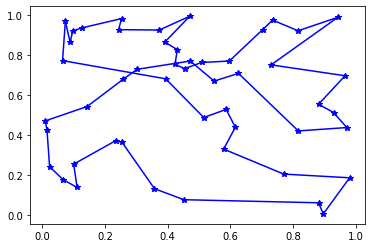

In [199]:
tsp.plot_cities(res)

In [715]:
# test
paths = np.zeros((2,10))
paths[0] = np.arange(10)
paths[1] = np.arange(9,-1,-1)


100